[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)



# 研究助理（Research Assistant）

## 评论（Review）

We've covered a few major LangGraph themes:

我们已经介绍了几个主要的 LangGraph 主题：

* Memory
* Human-in-the-loop
* Controllability

*内存* 人工参与循环  
* 可控性

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation. 

现在，我们将把这些想法结合起来，来应对人工智能最受欢迎的应用之一：研究自动化。

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

研究工作常常是繁琐的任务，并被分配给分析师。人工智能在协助这方面具有相当大的潜力。

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows. 

然而，研究需要定制化：原始的 LLM 输出通常不适合用于现实世界的决策工作流程。

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

定制化的、基于 AI 的 [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) 工作流是解决这一问题的有前景的方法。

## 目标（Goal）

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

我们的目标是围绕聊天模型构建一个轻量级、多智能体系统，以定制研究过程。

`Source Selection` 
* Users can choose any set of input sources for their research.
  
`Planning` 
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state. 
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Source Selection` 
* 用户可以选择任何一组输入源进行研究。
  
`Planning` 
*用户提供一个主题，系统将生成一个由 AI 分析师组成的团队，每位分析师专注于一个子主题。* `Human-in-the-loop` 将在研究开始前用于优化这些子主题。
  
`LLM Utilization`
*每位分析师将使用选定的来源与专家 AI 进行深入访谈。* 访谈将是一个多轮对话，以提取详细见解，如 [STORM](https://arxiv.org/abs/2402.14207) 论文中所示。
* 这些访谈将通过 `sub-graphs` 捕获，并记录其内部状态。
   
`Research Process`
*专家将在 `parallel` 中收集信息以回答分析师的问题。* 所有访谈将通过 `map-reduce` 同时进行。

`Output Format` 
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format. 

`Output Format`  
*每次访谈收集到的见解将被整合成一份最终报告。* 我们将使用可定制的提示语来生成报告，从而实现灵活的输出格式。

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)



In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## 设置（Setup）



In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [21]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model="qwen-plus-2025-07-14",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。



In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 生成分析师：人类在回路中（Generate Analysts: Human-In-The-Loop）

Create analysts and review them using human-in-the-loop.

创建分析师并使用人工循环（human-in-the-loop）来审查他们。



In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    """
    分析师模型类
    用于定义单个分析师的基本信息和属性
    """
    affiliation: str = Field(
        description="分析师的主要隶属机构。",
    )
    name: str = Field(
        description="分析师的姓名"
    )
    role: str = Field(
        description="分析师在该主题背景下的角色。",
    )
    description: str = Field(
        description="分析师的关注点、担忧和动机的描述。",
    )
    
    @property#@property 装饰器的作用是将一个方法转换为只读属性 ，让方法可以像访问属性一样使用，而不需要加括号调用。
    def persona(self) -> str:
        """
        生成分析师的人设信息
        返回格式化的字符串包含分析师的所有关键信息
        """
        return f"姓名: {self.name}\n角色: {self.role}\n隶属机构: {self.affiliation}\n描述: {self.description}\n"

class Perspectives(BaseModel):
    """
    视角模型类
    用于管理多个分析师的集合
    """
    analysts: List[Analyst] = Field(
        description="包含角色和隶属机构的分析师综合列表。",
    )

class GenerateAnalystsState(TypedDict):
    """
    生成分析师状态类型定义
    用于类型提示，定义在生成分析师过程中需要的状态信息
    """
    topic: str # 研究主题 - 用户输入的研究话题
    max_analysts: int # 分析师数量 - 需要生成的分析师最大数量
    human_analyst_feedback: str # 人类反馈 - 来自用户的反馈信息，用于调整分析师生成
    analysts: List[Analyst] # 提出问题的分析师 - 已生成的分析师列表

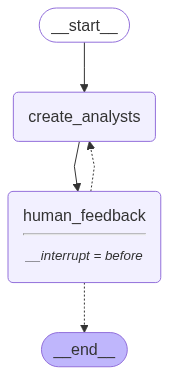

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# 分析师指令模板
analyst_instructions="""您需要创建一组AI分析师角色。请仔细遵循以下指令：

1. 首先，查看研究主题：
{topic}
        
2. 检查任何可选的编辑反馈，这些反馈用于指导分析师的创建： 
        
{human_analyst_feedback}
    
3. 根据上述文档和/或反馈确定最有趣的主题。
                    
4. 选择前 {max_analysts} 个主题。

5. 为每个主题分配一个分析师。

6. 重要：请以JSON格式返回您的响应，结构如下：
   {{
     "analysts": [
       {{
         "name": "分析师姓名",
         "affiliation": "所属机构",
         "role": "角色描述",
         "description": "详细描述"
       }}
     ]
   }}

7. 请确保响应中包含'json'这个词，这是必需的。"""

def create_analysts(state: GenerateAnalystsState):
    """ 创建分析师 """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')#防止为空
        
    # 强制结构化输出
    structured_llm = llm.with_structured_output(Perspectives)

    # 系统消息
    system_message = analyst_instructions.format(topic=topic,human_analyst_feedback=human_analyst_feedback, max_analysts=max_analysts)

    # 生成分析师
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="生成分析师集合。")])
    
    # 将分析师列表写入状态
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ 无操作节点，应该在此处中断 """
    pass

def should_continue(state: GenerateAnalystsState):
    """ 返回下一个要执行的节点 """

    # 检查是否有用户反馈
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # 否则结束
    return END

# 添加节点和边
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)  # 添加创建分析师节点
builder.add_node("human_feedback", human_feedback)   # 添加用户反馈节点
builder.add_edge(START, "create_analysts")           # 从开始到创建分析师
builder.add_edge("create_analysts", "human_feedback") # 从创建分析师到用户反馈
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END]) # 条件边

# 编译图
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)  # 在用户反馈前中断

# 显示图
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))  # 显示流程图

In [7]:
# 输入
max_analysts = 3  # 最大分析师数量
topic = "采用LangGraph作为代理框架的好处"  # 研究主题
thread = {"configurable": {"thread_id": "1"}}  # 线程配置，用于会话跟踪

# 运行图直到第一次中断
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # 审查结果
    analysts = event.get('analysts', '')  # 获取分析师列表
    if analysts:
        for analyst in analysts:
            print(f"姓名: {analyst.name}")        # 打印分析师姓名
            print(f"隶属机构: {analyst.affiliation}")  # 打印隶属机构
            print(f"角色: {analyst.role}")        # 打印角色
            print(f"描述: {analyst.description}")  # 打印描述
            print("-" * 50)  # 打印分隔线

姓名: 艾琳·史密斯
隶属机构: 智能系统研究所
角色: AI代理框架分析师
描述: 专注于LangGraph在复杂AI代理系统中的应用，特别是其在多智能体协作和可扩展性方面的优势。
--------------------------------------------------
姓名: 李承宇
隶属机构: 下一代AI实验室
角色: LangGraph性能优化专家
描述: 研究LangGraph在代理框架中如何提升系统性能，包括其状态管理、模块化设计和运行效率。
--------------------------------------------------
姓名: 索菲亚·马丁内斯
隶属机构: 人机交互与智能代理中心
角色: 用户体验与代理交互分析师
描述: 分析LangGraph如何改善AI代理的可解释性与用户交互体验，特别是在可视化流程和动态决策方面的潜力。
--------------------------------------------------


In [7]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
# 我们现在像 human_feedback 节点一样更新状态
graph.update_state(thread, {"human_analyst_feedback": 
                            "添加一个来自初创公司的人，以增加企业家视角"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f068316-4eaa-618c-8002-7b25abe6580c'}}

In [9]:
# 继续图的执行
for event in graph.stream(None, thread, stream_mode="values"):
    # 审查结果
    analysts = event.get('analysts', '')  # 获取分析师列表
    if analysts:
        for analyst in analysts:
            print(f"姓名: {analyst.name}")        # 打印分析师姓名
            print(f"隶属机构: {analyst.affiliation}")  # 打印隶属机构
            print(f"角色: {analyst.role}")        # 打印角色
            print(f"描述: {analyst.description}")  # 打印描述
            print("-" * 50)  # 打印分隔线


姓名: 艾琳·史密斯
隶属机构: 智能系统研究所
角色: AI代理框架分析师
描述: 专注于LangGraph在复杂AI代理系统中的应用，特别是其在多智能体协作和可扩展性方面的优势。
--------------------------------------------------
姓名: 李承宇
隶属机构: 下一代AI实验室
角色: LangGraph性能优化专家
描述: 研究LangGraph在代理框架中如何提升系统性能，包括其状态管理、模块化设计和运行效率。
--------------------------------------------------
姓名: 索菲亚·马丁内斯
隶属机构: 人机交互与智能代理中心
角色: 用户体验与代理交互分析师
描述: 分析LangGraph如何改善AI代理的可解释性与用户交互体验，特别是在可视化流程和动态决策方面的潜力。
--------------------------------------------------
姓名: 艾米丽·陈
隶属机构: 斯坦福人工智能实验室
角色: AI架构专家
描述: 专注于代理框架和分布式AI系统设计，提供对LangGraph技术优势的深度分析。
--------------------------------------------------
姓名: 拉胡尔·帕特尔
隶属机构: 初创公司创始人兼CEO
角色: 企业家与技术战略家
描述: 从初创公司视角探讨LangGraph的实用性和商业化潜力，强调其在资源受限环境下的优势。
--------------------------------------------------
姓名: 迈克尔·罗德里格斯
隶属机构: 麻省理工学院计算机科学与人工智能实验室
角色: 代理系统研究员
描述: 研究多代理系统与LangGraph框架的集成能力，分析其对复杂任务处理的优化效果。
--------------------------------------------------


In [10]:
# 如果我们满意，那么就不提供任何反馈
further_feedback = None 
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f068316-a2d4-6b70-8004-e669e52e0cff'}}

In [15]:
# 继续图的执行直到结束
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
human_feedback
--Node--
create_analysts
--Node--
__interrupt__


In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [13]:
final_state.next

()

In [14]:
for analyst in analysts:
    print(f"姓名: {analyst.name}")        # 打印分析师姓名
    print(f"隶属机构: {analyst.affiliation}")  # 打印隶属机构
    print(f"角色: {analyst.role}")        # 打印角色
    print(f"描述: {analyst.description}")  # 打印描述
    print("-" * 50)  # 打印分隔线

姓名: 艾米丽·陈
隶属机构: 斯坦福人工智能实验室
角色: AI架构专家
描述: 专注于代理框架和分布式AI系统设计，提供对LangGraph技术优势的深度分析。
--------------------------------------------------
姓名: 拉胡尔·帕特尔
隶属机构: 初创公司创始人兼CEO
角色: 企业家与技术战略家
描述: 从初创公司视角探讨LangGraph的实用性和商业化潜力，强调其在资源受限环境下的优势。
--------------------------------------------------
姓名: 迈克尔·罗德里格斯
隶属机构: 麻省理工学院计算机科学与人工智能实验室
角色: 代理系统研究员
描述: 研究多代理系统与LangGraph框架的集成能力，分析其对复杂任务处理的优化效果。
--------------------------------------------------


## 进行面试（Conduct Interview）

### 生成问题（Generate Question）

The analyst will ask questions to the expert.

分析师将向专家提问。



In [6]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    """
    访谈状态类
    继承自MessagesState，用于管理访谈过程中的各种状态信息
    """
    max_num_turns: int # 对话轮数上限
    context: Annotated[list, operator.add] # 源文档，使用operator.add进行合并
    analyst: Analyst # 提问的分析师
    interview: str # 访谈记录（文字记录）
    sections: list # 最终章节，我们在外部状态中重复此字段以用于Send() API

class SearchQuery(BaseModel):
    """
    搜索查询模型
    用于定义搜索查询的结构
    """
    search_query: str = Field(None, description="用于检索的搜索查询。")

In [7]:
# 问题生成指令
question_instructions = """你是一名分析师，任务是采访专家以了解特定主题。

你的目标是提炼出与你主题相关的有趣且具体的见解。

1. 有趣的：人们会感到惊讶或不明显的见解。
        
2. 具体的：避免泛泛而谈的见解，包含来自专家的具体例子。

这是你的关注主题和目标集合：{goals}
        
首先使用符合你人设的名字介绍自己，然后提出你的问题。

继续提问以深入挖掘和细化你对该主题的理解。
        
当你对理解满意时，用"非常感谢您的帮助！"来结束采访。

记住在整个回复中保持角色特征，体现提供给你的人设和目标。"""

def generate_question(state: InterviewState):
    """ 生成问题的节点 """

    # 获取状态
    analyst = state["analyst"]      # 当前分析师
    messages = state["messages"]    # 对话历史

    # 生成问题
    system_message = question_instructions.format(goals=analyst.persona)  # 格式化系统消息
    question = llm.invoke([SystemMessage(content=system_message)]+messages)  # 调用LLM生成问题
        
    # 将消息写入状态
    return {"messages": [question]}  # 返回新生成的问题

### Generate Answer: Parallelization
The expert will gather information from multiple sources in parallel to answer questions.

专家将并行从多个来源收集信息以回答问题。

For example, we can use:

例如，我们可以使用：

* Specific web sites e.g., via [PROTECTED$11$](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* Indexed documents e.g., via [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* Web search
* Wikipedia search

*特定网站，例如，通过 [PROTECTED$11$](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)* 已索引文档，例如，通过 [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
*网络搜索* Wikipedia 搜索

You can try different web search tools, like [Tavily](https://tavily.com/).

你可以尝试不同的网络搜索工具，比如 [Tavily](https://tavily.com/)。



In [8]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [9]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
tavily_search = TavilySearchResults(max_results=3)
#tavily_search=TavilySearch(max_results=3)

C:\Users\29020\AppData\Local\Temp\ipykernel_38724\3355271073.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [10]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [12]:
loader = WikipediaLoader(
    query="LangGraph",  # 搜索关键词
    lang="en",                        # 语言代码，默认是英文
    load_max_docs=1,                  # 最多加载几篇文档
    doc_content_chars_max=4000        # 每篇文档最大字符数
)

docs = loader.load()

In [55]:
vars(docs[0])

{'id': None,
 'metadata': {'title': 'C (programming language)',
  'summary': 'C is a general-purpose programming language. It was created in the 1970s by Dennis Ritchie and remains widely used and influential. By design, C gives the programmer relatively direct access to the features of the typical CPU architecture; customized for the target instruction set. It has been and continues to be used to implement operating systems (especially kernels), device drivers, and protocol stacks, but its use in application software has been decreasing. C is used on computers that range from the largest supercomputers to the smallest microcontrollers and embedded systems.\nA successor to the programming language B, C was originally developed at Bell Labs by Ritchie between 1972 and 1973 to construct utilities running on Unix. It was applied to re-implementing the kernel of the Unix operating system. During the 1980s, C gradually gained popularity. It has become one of the most widely used programming

In [56]:
print(docs[0])

page_content='C is a general-purpose programming language. It was created in the 1970s by Dennis Ritchie and remains widely used and influential. By design, C gives the programmer relatively direct access to the features of the typical CPU architecture; customized for the target instruction set. It has been and continues to be used to implement operating systems (especially kernels), device drivers, and protocol stacks, but its use in application software has been decreasing. C is used on computers that range from the largest supercomputers to the smallest microcontrollers and embedded systems.
A successor to the programming language B, C was originally developed at Bell Labs by Ritchie between 1972 and 1973 to construct utilities running on Unix. It was applied to re-implementing the kernel of the Unix operating system. During the 1980s, C gradually gained popularity. It has become one of the most widely used programming languages, with C compilers available for practically all modern

Now, we create nodes to search the web and wikipedia.

现在，我们创建节点以搜索网络和维基百科。

We'll also create a node to answer analyst questions.

我们还将创建一个节点来回答分析师的问题。

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

最后，我们将创建节点以保存完整的采访内容，并撰写采访的摘要（“部分”）。



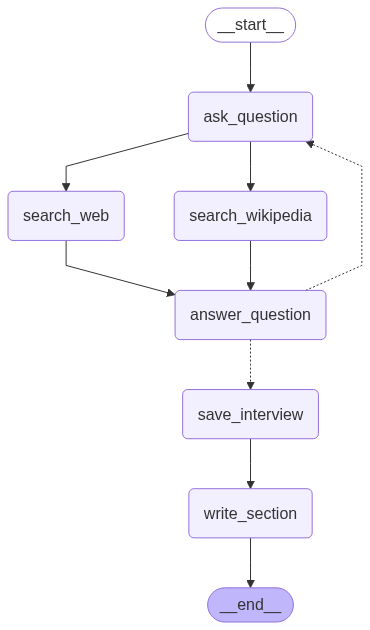

In [ ]:
from langchain_core.messages import get_buffer_string

# 搜索查询编写
search_instructions = SystemMessage(content=f"""你将获得分析师和专家之间的对话。

你的目标是生成一个结构化的 JSON 对象，该对象包含一个用于网络搜索的查询字符串。

请严格按照以下步骤操作：

1.  仔细分析整个对话。
2.  特别关注分析师提出的最后一个问题。
3.  根据该问题，生成一个清晰、简洁、有效的搜索查询字符串。
4.  **你的最终输出必须是一个严格的 JSON 对象，格式如下，不要包含任何其他文字或解释：**
    {{"search_query": "你的查询字符串放在这里"}}

**示例：**
如果最后一个问题涉及 "LangGraph 与其他代理框架（如 AutoGen）相比的优势"，
你的输出必须严格是：
{{"search_query": "LangGraph vs AutoGen agent framework advantages"}}

分析师的最后一个问题才是关键，请基于它生成查询。

**你的输出：**""")

def search_web(state: InterviewState):
    
    """ 从网络搜索中检索文档 """

    # 搜索查询
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # 搜索
    search_docs = tavily_search.invoke(search_query.search_query)

     # 格式化
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ 从维基百科检索文档 """

    # # 搜索查询
    # structured_llm = llm.with_structured_output(SearchQuery)
    # search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # # 搜索
    # search_docs = WikipediaLoader(query=search_query.search_query, 
    #                               load_max_docs=2).load()

    #  # 格式化
    # formatted_search_docs = "\n\n---\n\n".join(
    #     [
    #         f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
    #         for doc in search_docs
    #     ]
    # )

    # return {"context": [formatted_search_docs]} 
    return {"context": [""]}

answer_instructions = """你是一位正在接受分析师采访的专家。

这是分析师的关注领域：{goals}。
        
你的目标是回答面试官提出的问题。

要回答问题，请使用此上下文：
        
{context}

回答问题时，请遵循以下准则：
        
1. 仅使用上下文中提供的信息。
        
2. 不要引入外部信息或在上下文中明确说明之外进行假设。

3. 上下文包含每个独立文档主题的来源。

4. 在任何相关陈述旁边包含这些来源。例如，对于来源 # 1 使用 [1]。

5. 在答案底部按顺序列出你的来源。 [1] 来源 1，[2] 来源 2，等等
        
6. 如果来源是：<Document source="assistant/docs/llama3_1.pdf" page="7"/>' 那么只需列出：
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
并跳过括号的添加以及引用中的 Document source 前言。"""

def generate_answer(state: InterviewState):
    
    """ 回答问题的节点 """

    # 获取状态
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 回答问题
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # 将消息命名为来自专家
    answer.name = "expert"
    
    # 将其附加到状态
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ 保存采访 """

    # 获取消息
    messages = state["messages"]
    
    # 将采访转换为字符串
    interview = get_buffer_string(messages)
    
    # 保存到 interviews 键
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ 在问题和答案之间路由 """
    
    # 获取消息
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # 检查专家答案的数量
    #isinstance(m, AIMessage) ：检查当前消息 m 是否是 AIMessage 类的实例。这通常用于识别由 AI 模型生成的消息。
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 如果专家回答的次数超过最大轮数，则结束
    if num_responses >= max_num_turns:
        return 'save_interview'

    # 获取提出的最后一个问题，以检查它是否表示讨论结束
    #messages[-2] ：分析师提出的 最后一个问题 。
    #messages[-1] ：专家对这个问题的 最新回答 。
    last_question = messages[-2]
    
    if "非常感谢你的帮助" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """你是一位专业的科技作家。
            
你的任务是根据一组源文档创建一份简短、易于理解的报告部分。

1. 分析源文档的内容：
- 每个源文档的名称都在文档开头，带有 <Document 标签。
        
2. 使用 markdown 格式创建报告结构：
- 使用 ## 作为章节标题
- 使用 ### 作为小节标题
        
3. 按照此结构编写报告：
a. 标题 (## header)
b. 摘要 (### header)
c. 来源 (### header)

4. 根据分析师的关注领域，使你的标题引人入胜：
{focus}

5. 对于摘要部分：
- 设置与分析师关注领域相关的通用背景/上下文的摘要
- 强调从采访中收集到的新颖、有趣或令人惊讶的见解
- 创建一个使用过的源文档的编号列表
- 不要提及面试官或专家的姓名
- 目标是最多约 400 字
- 根据源文档中的信息，在报告中使用编号来源（例如，[1]、[2]）
        
6. 在来源部分：
- 包含报告中使用的所有来源
- 提供相关网站或特定文档路径的完整链接
- 每个来源用换行符分隔。在每行末尾使用两个空格以在 Markdown 中创建换行符。
- 它看起来像：

### 来源
[1] 链接或文档名称
[2] 链接或文档名称

7. 务必合并来源。例如，这不正确：

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

不应有冗余来源。它应该只是：

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. 最终审查：
- 确保报告遵循所需的结构
- 在报告标题之前不包含任何前言
- 检查所有准则是否已遵循"""

def write_section(state: InterviewState):

    """ 编写章节的节点 """

    # 获取状态
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # 使用从采访（上下文）或采访本身（interview）收集的源文档编写章节
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # 将其附加到状态
    return {"sections": [section.content]}

# 添加节点和边
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 流程
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 采访
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# 视图
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [38]:
# 选择一个分析师
analysts[0]

Analyst(affiliation='斯坦福人工智能实验室', name='艾米丽·陈', role='AI架构专家', description='专注于代理框架和分布式AI系统设计，提供对LangGraph技术优势的深度分析。')

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

在这里，我们运行采访，传递 llama3.1 论文的索引，该论文与我们的主题相关。



In [39]:
print(messages)

[SystemMessage(content='You are a helpful assistant that outputs JSON.', additional_kwargs={}, response_metadata={}, id='5dd96d10-7f2a-45cc-8641-4efe4866dd90'), HumanMessage(content='所以你说你正在写一篇关于采用LangGraph作为代理框架的好处的文章？', additional_kwargs={}, response_metadata={}, id='a421d8ab-0dc2-4087-817b-a4e7e536a7cc')]


In [46]:
from IPython.display import Markdown

messages = [
    SystemMessage("You are a helpful assistant that outputs JSON."), # 添加这一行
    HumanMessage(f"所以你说你正在写一篇关于{topic}的文章？")
]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph：多智能体系统架构的革新与技术优势

### 摘要

随着生成式AI的快速发展，多智能体系统（Multi-Agent Systems）正从理论走向实际生产应用。LangGraph作为LangChain生态系统中的扩展框架，为构建复杂的AI代理工作流提供了强大的图结构支持。其核心优势在于引入了**循环计算能力**，突破了传统DAG（有向无环图）的线性限制，使代理能够根据动态状态进行循环推理和决策，从而实现更高级的自主行为 [3]。

LangGraph通过**状态持久化**和**图结构编排**，使开发者能够构建具有多步骤、多角色、多逻辑分支的AI系统，尤其适合RAG增强检索、对话系统、任务分解与协作等场景 [5]。此外，它支持模块化设计、函数智能调用、易于调试与日志追踪等特性，显著提升了开发效率和系统的可维护性 [1]。与AutoGen相比，LangGraph以图为核心的设计理念，使复杂工作流的定义更加直观和灵活 [4]。

在实际应用中，LangGraph已被用于构建可扩展的智能代理系统，例如挪威邮轮公司将其用于优化客户体验的AI解决方案 [2]。同时，LangGraph还支持与OpenTelemetry集成，为生成式AI代理提供插桩能力，实现对推理过程的可视化、监控与优化 [6]。

这些特性表明，LangGraph不仅是构建多智能体系统的技术利器，也为AI工程化落地提供了坚实基础。

### 来源  
[1] https://metadesignsolutions.com/how-to-build-multi-agent-systems-using-langgraph-and-openai-functions/  
[2] https://www.ibm.com/think/topics/langgraph  
[3] https://medium.com/pythoneers/building-ai-agent-systems-with-langgraph-9d85537a6326  
[4] https://hub.baai.ac.cn/view/36671  
[5] https://kilong31442.medium.com/langgraph-lowlevel-important-concepts-2b8a61499cc5  
[6] https://cloud.google.com/stackdriver/docs/instrumentation/ai-agent-overview?hl=zh-cn

### 并行化访谈：Map-Reduce（Parallelze interviews: Map-Reduce）

We parallelize the interviews via the `Send()` API, a map step.

我们通过 `Send()` API 并行化处理访谈，这是一个映射步骤。

We combine them into the report body in a reduce step.

我们将它们在 reduce 步骤中组合成报告正文。

### 最终确定（Finalize）

We add a final step to write an intro and conclusion to the final report.

我们添加最后一个步骤，为最终报告撰写引言和结论。



In [14]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str                           # 研究主题 (字符串类型)
    max_analysts: int                   # 分析师数量 (整数类型)
    human_analyst_feedback: str         # 人类分析师的反馈 (字符串类型)
    analysts: List[Analyst]             # 提问的分析师列表 (Analyst 对象的列表)
    sections: Annotated[list, operator.add] # 报告章节列表 (使用 operator.add 作为 Send() API 的键，意味着列表可以通过相加来合并)
    introduction: str                   # 最终报告的引言部分 (字符串类型)
    content: str                        # 最终报告的内容主体部分 (字符串类型)
    conclusion: str                     # 最终报告的结论部分 (字符串类型)
    final_report: str                   # 最终完整的报告 (字符串类型)

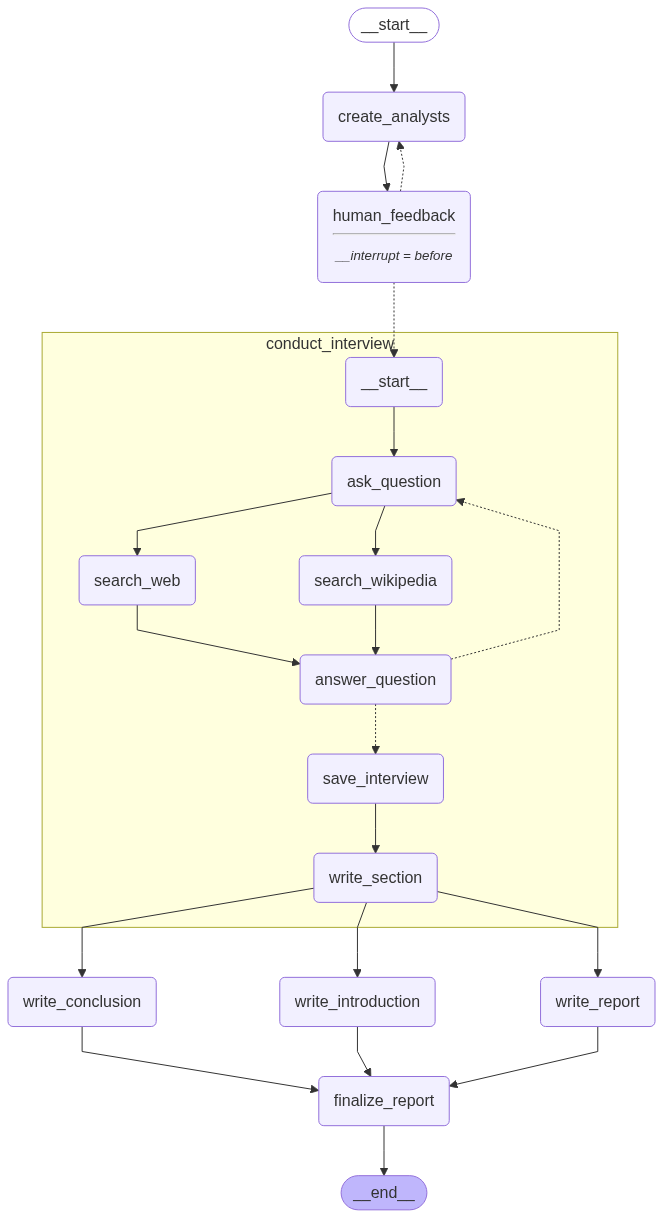

In [15]:
# 从 langgraph.constants 导入 Send 类
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ 这是“map”（映射）步骤，我们使用 Send API 并行运行每个采访子图 """

    # 检查是否存在人类反馈
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # 如果有反馈，则返回到 "create_analysts" 节点进行调整
        return "create_analysts"

    # 否则，通过 Send() API 并行启动所有采访
    else:
        topic = state["topic"]
        # 为每个分析师创建一个 Send 对象
        # 目标是 "conduct_interview" 节点
        # 传递的参数包括该分析师对象和一条初始消息
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"所以你说你正在写一篇关于 {topic} 的文章？"
                                           )
                                                       ]}) for analyst in state["analysts"]]

# 定义用于撰写最终报告的指令模板
report_writer_instructions = """你是一位正在撰写关于以下主题报告的技术作家：

{topic}
    
你有一个分析师团队。每个分析师做了两件事：

1. 他们就一个特定的子主题与专家进行了采访。
2. 他们将他们的发现写成了一份备忘录。

你的任务：

1. 你将得到一份来自你所有分析师的备忘录集合。
2. 仔细思考每份备忘录中的见解。
3. 将这些见解整合成一个清晰的整体摘要，把所有备忘录中的核心思想联系起来。
4. 将每份备忘录中的要点总结成一个连贯的单一叙述。

报告格式要求：
 
1. 使用 Markdown 格式。
2. 报告开头不要有前言。
3. 不要使用子标题。
4. 报告开头使用一个一级标题：## Insights （## 见解）
5. 在报告中不要提及任何分析师的名字。
6. 保留备忘录中的所有引用，这些引用会用方括号标注，例如 [1] 或 [2]。
7. 创建一个最终的、合并的来源列表，并添加到以 `## Sources` 为标题的部分。
8. 按顺序列出你的来源，不要重复。

[1] 来源 1
[2] 来源 2

以下是你的分析师提供的备忘录，你需要根据它们来撰写报告：

{context}"""

def write_report(state: ResearchGraphState):
    """ 撰写报告主体内容的节点函数 """
    # 获取所有章节（备忘录）
    sections = state["sections"]
    topic = state["topic"]

    # 将所有章节（备忘录）连接成一个字符串
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # 使用指令模板和备忘录内容，调用 LLM 生成最终报告
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="根据这些备忘录写一份报告。")]) 
    # 返回报告内容
    return {"content": report.content}

# 定义用于撰写引言和结论的指令模板
intro_conclusion_instructions = """你是一位正在完成关于 {topic} 报告的技术作家。

你将得到报告的所有章节。

你的工作是撰写一个清晰且有说服力的引言或结论部分。

用户会指示你是写引言还是结论。

两个部分都不要有前言。

目标大约 100 个词，简洁地预览（对于引言）或回顾（对于结论）报告的所有章节。

使用 Markdown 格式。

对于你的引言，创建一个引人注目的标题，并使用 # 标题级别。
对于你的引言，使用 ## Introduction （## 引言） 作为部分标题。

对于你的结论，使用 ## Conclusion （## 结论） 作为部分标题。

以下是供你参考以撰写相应部分的章节：{formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    """ 撰写报告引言的节点函数 """
    # 获取所有章节
    sections = state["sections"]
    topic = state["topic"]

    # 将所有章节连接成一个字符串
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # 使用指令模板和章节内容，调用 LLM 生成引言
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions] + [HumanMessage(content="写报告的引言")]) 
    # 返回引言内容
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    """ 撰写报告结论的节点函数 """
    # 获取所有章节
    sections = state["sections"]
    topic = state["topic"]

    # 将所有章节连接成一个字符串
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # 使用指令模板和章节内容，调用 LLM 生成结论
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions] + [HumanMessage(content="写报告的结论")]) 
    # 返回结论内容
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ 这是“reduce”（归约）步骤，我们收集所有部分，将它们组合起来，并进行反思以写出引言/结论 """
    """ 最终整合报告的节点函数 """
    # 获取报告主体内容
    content = state["content"]
    # 如果内容以 "## Insights" 开头，则移除这个标题
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    # 尝试分离报告主体和来源部分
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None # 如果分离失败，则来源部分为空
    else:
        sources = None

    # 将引言、主体内容和结论连接起来形成最终报告
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    # 如果存在来源部分，则将其附加到最终报告末尾
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    # 返回最终报告
    return {"final_report": final_report}

# 添加节点和边
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile()) # 将之前定义的采访图编译后作为一个节点
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 定义工作流逻辑
builder.add_edge(START, "create_analysts") # 从开始到创建分析师
builder.add_edge("create_analysts", "human_feedback") # 创建分析师后进入人类反馈环节
# 条件边：根据 human_feedback 节点的输出，决定是回到创建分析师还是开始采访
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"]) 
# 采访完成后，并行执行撰写报告、引言和结论
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
# 撰写完报告的三个部分后，汇聚到最终整合步骤
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END) # 最终整合后结束

# 编译图
memory = MemorySaver()
# 编译图，并设置在 'human_feedback' 节点前中断，以及使用检查点保存器
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
# 显示图的可视化表示
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

让我们提出一个关于 LangGraph 的开放式问题。



In [16]:
# Inputs
max_analysts = 3 
topic = "采用 LangGraph 作为代理框架的好处"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 艾米丽·陈
Affiliation: 斯坦福人工智能实验室
Role: AI系统架构分析师
Description: 专注于代理框架的架构设计与优化，特别是如何利用LangGraph提高复杂AI系统的模块化和可扩展性。
--------------------------------------------------
Name: 拉胡尔·帕特尔
Affiliation: 麻省理工学院计算机科学与人工智能实验室
Role: 多智能体系统分析师
Description: 研究重点是如何使用LangGraph构建高效的多智能体系统，以实现更强大的协作与决策能力。
--------------------------------------------------
Name: 索菲亚·罗德里格斯
Affiliation: 伯克利数据科学研究所
Role: AI代理性能分析师
Description: 致力于分析LangGraph在不同应用场景下的性能表现，评估其在效率、灵活性和可维护性方面的优势。
--------------------------------------------------


In [17]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f068f67-e9eb-67cb-8002-5a6dd3bcc83f'}}

In [18]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: 艾米丽·陈
Affiliation: 斯坦福人工智能实验室
Role: AI系统架构分析师
Description: 专注于代理框架的架构设计与优化，特别是如何利用LangGraph提高复杂AI系统的模块化和可扩展性。
--------------------------------------------------
Name: 拉胡尔·帕特尔
Affiliation: 麻省理工学院计算机科学与人工智能实验室
Role: 多智能体系统分析师
Description: 研究重点是如何使用LangGraph构建高效的多智能体系统，以实现更强大的协作与决策能力。
--------------------------------------------------
Name: 索菲亚·罗德里格斯
Affiliation: 伯克利数据科学研究所
Role: AI代理性能分析师
Description: 致力于分析LangGraph在不同应用场景下的性能表现，评估其在效率、灵活性和可维护性方面的优势。
--------------------------------------------------
Name: Dr. Emily Zhang
Affiliation: AI Research Labs, Inc.
Role: 首席人工智能分析师
Description: 专注于代理框架与多智能体系统在企业级AI中的应用，Emily 为 LangGraph 在构建可扩展和可解释性AI架构中的作用提供深刻见解。
--------------------------------------------------
Name: Raj Patel
Affiliation: NextGen AI Ventures
Role: AI架构与工程专家
Description: Raj 深入研究 LangGraph 在简化复杂AI系统开发流程方面的优势，特别是在分布式代理协作和实时决策中的表现。
--------------------------------------------------
Name: Alex Chen
Affiliation: GenAI初创公司首席执行官
Role: 生成式AI产品与战略领导者
Description: 作为生成式AI原生初创公司的CE

In [19]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f068f68-69e8-6b52-8004-5b68450ef50a'}}

In [20]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current requests list.', 'type': 'limit_requests', 'param': None, 'code': 'limit_requests'}, 'request_id': '9eee31d6-4f19-952f-a95a-f5dda4c15f73'}

In [64]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

<IPython.core.display.Markdown object>

We can look at the trace:

我们可以查看轨迹：

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r
